# Three machine nine bus system

The model of Three Machine Nine Bus system in the conference version including the differental equations of synchronous machines, IEEE type 1 exciter system, and algebraic equation of stators and network balances.

**Differential equations**

synchronus machine:
\begin{align}
%
    T'_{qoi}\frac{\text{d} E'_{di}}{\text{d} t} &= -E'_{di} + (X_{qi} - X'_{qi})I_{qi} \label{eq: 1a}\\
%
  T'_{doi}\frac{\text{d} E'_{qi}}{\text{d} t} &= -E'_{qi} - (X_{di} - X'_{di})I_{di} + E_{fdi}  \label{eq: 1b}\\
  %
    \frac{\text{d} \delta_{i}}{\text{d} t} & = \omega_{i} - \omega_{s}  \label{eq: 1c}\\
%
    \frac{2H_{i}}{\omega_{s}} \frac{\text{d} \omega_{i}}{\text{d} t} &= T_{Mi} - E'_{di}I_{di} -  E'_{qi}I_{qi}- (X'_{qi}-X'_{di})I_{di}I_{qi} - D_{i}(\omega_{i}-\omega_{s})  \label{eq: 1d}\\
   & \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \forall i= 1, \ldots, m \nonumber.
\end{align}
IEEE type 1 exciter:
\begin{align}  
    T_{Ei}\frac{\text{d} E_{fdi}}{\text{d} t} & = -(K_{Ei}+S_{Ei}(E_{fdi}))E_{fdi}+V_{Ri} \label{eq: 1e}\\
%
    T_{Fi}\frac{\text{d} R_{fi}}{\text{d} t} & = - R_{fi}+\frac{K_{Fi}}{T_{Fi}} E_{fdi} \label{eq: 1f}
\\
    T_{Ai}\frac{\text{d} V_{Ri}}{\text{d} t} & = -V_{Ri}+K_{Ai}R_{fi} -\frac{K_{Ai}K_{Fi}}{T_{Fi}}E_{fdi}+K_{Ai}(V_{refi}-V_{i})  \label{eq: 1g}\\
   & \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \forall i= 1, \ldots, m \nonumber.
\end{align}

**Algebraic equations**

Stator equations:
\begin{align}
    E'_{di}-V_{i}\sin(\delta_{i}-\theta_i)+X'_{qi}I_{qi} = 0 \label{eq: 2a}\\
%
    E'_{qi}-V_{i}\cos(\delta_{i}-\theta_i)-X'_{di}I_{di} = 0
    \label{eq: 2b}\\
%
    \forall  i=1,\ldots,m, \notag
\end{align}
Network balances: for m buses with synchronous machine:
\begin{align}
I_{di}V_{i}\sin(\delta_{i}-\theta_{i})+I_{qi}V_{i}\cos(\delta_{i}-\theta_{i})  -P_{Li}
    =\sum^{n}_{k=1}V_{i}V_{k}Y_{ik}\cos(\theta_{i}-\theta_{k}-\alpha_{ik})\label{eq: 3a}\\
%   
    I_{di}V_{i}\cos(\delta_{i} -\theta_{i})-I_{qi}V_{i}\sin(\delta_{i}-\theta_{i}) - Q_{Li}  =\sum^{n}_{k=1}V_{i}V_{k}Y_{ik}\sin(\theta_{i}-\theta_{k}-\alpha_{ik}) \label{eq: 3b} \\
    \quad \quad \quad \quad i = 1,\ldots,m, \nonumber
\end{align}
for $n - m$ remaining load buses:
\begin{align}
-P_{Li} =  \sum^{n}_{k=1} V_{i}V_{k}Y_{ik}\cos(\theta_{i}-\theta_{k}-\alpha_{ik}) \label{eq: 3c}\\
%
    -Q_{Li}  = \sum^{n}_{k=1} V_{i}V_{k}Y_{ik}\sin(\theta_{i}-\theta_{k}-\alpha_{ik}) \label{eq: 3d} \\
     i = m+1,\ldots,n. \nonumber
\end{align}

In [1]:
#Import packages.
using QuDiffEq                # package containt quantum computing' solvers.
using OrdinaryDiffEq          # package containt solvers to solve ODEs.
using ModelingToolkit         # package to convert DAEs to ODEs.
using DifferentialEquations   # package containt solvers to solve differential equations.
using Plots                   # package to plot the figure
using LaTeXStrings            # oackage to type LaTex in the Julia

#### Import data

In [2]:
using CSV               #package to load and save CSV files.
using DataFrames        #package to create dataframe from array.

#Load parameter for three machine nine bus system.
data = CSV.File("3gens.csv");

#### Define parameters and implement DAEs.

In [3]:
@variables t (Eq(t))[1:3] (Ed(t))[1:3] (delta(t))[1:3] (omega(t))[1:3] (Efd(t))[1:3] (Rf(t))[1:3] (Vr(t))[1:3]   # set of state variables
@variables (V(t))[1:9] (theta(t))[1:9] (Id(t))[1:3] (Iq(t))[1:3] (TM(t))[1:3] (Psv(t))[1:3] (Pc(t))[1:3]         # continuous of set of state variable
@parameters LP5 LQ5 LP6 LQ6 LP8 LQ8                 #Set of active and reactive power at loads 5, 6 and 8.
D = Differential(t)       # define the differential operator D by time t.
omega_s = 120*pi          # reference speed.

#Sets of DAEs.

#Synchronous machone's dynamics
eq1 = [D(Eq[i]) ~ -(Eq[i] + (data["Xd"][i]-data["Xd'"][i])*Id[i] - Efd[i])/data["Tdo"][i] for i in 1:3]

eq2 = [D(Ed[i]) ~ -(Ed[i] - (data["Xq"][i]-data["Xq'"][i])*Iq[i])/data["Tqo"][i] for i in 1:3]

eq3 = [D(delta[i]) ~ omega[i]-omega_s for i in 1:3]

eq4 = [D(omega[i]) ~ (-(-data["TM"][i] + Ed[i]*Id[i] + Eq[i]*Iq[i] + (data["Xq'"][i]-data["Xd'"][i])*Id[i]*Iq[i])/(2*data["H"][i])*omega_s 
        - 0.1*i*(omega[i]-omega_s)) for i in 1:3]

#Exciter's dynamics
eq5 = [D(Efd[i]) ~  -((data["KE"][i] + 0.0039*exp(1.555*Efd[i]))*Efd[i] - Vr[i])/data["TE"][i] for i in 1:3]

eq6 = [D(Rf[i]) ~  -(Rf[i] + (- data["KF"][i]*Efd[i]/data["TF"][i]))/data["TF"][i] for i in 1:3]

eq7 = [D(Vr[i]) ~  (-(Vr[i] - data["KA"][i]*Rf[i] + data["KA"][i]*data["KF"][i]*Efd[i]/data["TF"][i] 
            - data["KA"][i]*(data["Vref"][i]-V[i]))/data["TA"][i]) for i in 1:3]

#Stator equations
eq8 = [0~ Ed[i] - V[i]*sin(delta[i]-theta[i]) + data["Xq'"][i]*Iq[i]  for i in 1:3]

eq9 = [0~ Eq[i] - V[i]*cos(delta[i]-theta[i]) - data["Xd'"][i]*Id[i]  for i in 1:3]

#Network flow balances.
eq10 = [
    #Real power
    #bus 1
    0 ~ Id[1]*V[1]*sin(delta[1]-theta[1]) + Iq[1]*V[1]*cos(delta[1]-theta[1]) - 17.36*V[1]*V[4]*sin(theta[1]-theta[4]),
    #bus 2
    0 ~ Id[2]*V[2]*sin(delta[2]-theta[2]) + Iq[2]*V[2]*cos(delta[2]-theta[2]) - 16*V[2]*V[7]*sin(theta[2]-theta[7]),
    #bus 3
    0 ~ Id[3]*V[3]*sin(delta[3]-theta[3]) + Iq[3]*V[3]*cos(delta[3]-theta[3]) - 17.07*V[3]*V[9]*sin(theta[3]-theta[9]),
    #bus 4
    0 ~ (-17.36*V[4]*V[1]*sin(theta[4]-theta[1]) - 3.31*V[4]^2 + 1.36*V[4]*V[5]*cos(theta[4]-theta[5]) 
        - 11.6*V[4]*V[5]*sin(theta[4]-theta[5]) + 1.942*V[4]*V[6]*cos(theta[4]-theta[6]) - 10.51*V[4]*V[6]*sin(theta[4]-theta[6])),
    #bus 5
    0 ~ (LP5 + 1.36*V[5]*V[4]*cos(theta[5]-theta[4]) - 11.6*V[5]*V[4]*sin(theta[5]-theta[4]) + 1.19*V[5]*V[7]*cos(theta[5]-theta[7])
    - 5.97*V[5]*V[7]*sin(theta[5]-theta[7]) - 2.55*V[5]^2),
    #bus 6
    0 ~ (LP6 + 1.942*V[6]*V[4]*cos(theta[6]-theta[4]) - 10.51*V[6]*V[4]*sin(theta[6]-theta[4]) -3.22*V[6]^2 
        + 1.28*V[6]*V[9]*cos(theta[6]-theta[9]) - 5.59*V[6]*V[9]*sin(theta[6]-theta[9])),
    #bus 7
    0 ~ (-16*V[2]*V[7]*sin(theta[7]-theta[2]) + 1.19*V[7]*V[5]*cos(theta[7]-theta[5]) - 5.97*V[7]*V[5]*sin(theta[7]-theta[5])
        -2.8*V[7]^2 + 1.62*V[7]*V[8]*cos(theta[7]-theta[8]) - 13.7*V[7]*V[8]*sin(theta[7]-theta[8])),
    #bus 8
    0 ~ (LP8 + 1.62*V[8]*V[7]*cos(theta[8]-theta[7]) - 13.7*V[8]*V[7]*sin(theta[8]-theta[7]) - 2.77*V[8]^2
    + 1.16*V[8]*V[9]*cos(theta[8]-theta[9]) - 9.78*V[8]*V[9]*sin(theta[8]-theta[9])),
    #bus 9
    0 ~ (-2.4*V[9]^2 - 17.07*V[9]*V[3]*sin(theta[9]-theta[3]) + 1.28*V[9]*V[6]*cos(theta[9]-theta[6]) - 5.59*V[9]*V[6]*sin(theta[9]-theta[6])
        + 1.16*V[9]*V[8]*cos(theta[9]-theta[8]) - 9.78*V[9]*V[8]*sin(theta[9]-theta[8])),
    #Reactive power
    #bus 1
    0 ~ Id[1]*V[1]*cos(delta[1]-theta[1]) - Iq[1]*V[1]*sin(delta[1]-theta[1]) + 17.36*V[1]*V[4]*cos(theta[1]-theta[4]) - 17.36*V[1]^2,
    #bus 2
    0 ~ Id[2]*V[2]*cos(delta[2]-theta[2]) - Iq[2]*V[2]*sin(delta[2]-theta[2]) + 16*V[2]*V[7]*cos(theta[2]-theta[7]) - 16*V[2]^2,
    #bus 3
    0 ~ Id[3]*V[3]*cos(delta[3]-theta[3]) - Iq[3]*V[3]*sin(delta[3]-theta[3]) + 17.07*V[3]*V[9]*cos(theta[3]-theta[9]) - 17.07*V[3]^2,
    #bus 4
    0 ~ (17.36*V[4]*V[1]*cos(theta[4]-theta[1]) - 39.3*V[4]^2 + 1.36*V[4]*V[5]*sin(theta[4]-theta[5]) 
        + 11.6*V[4]*V[5]*cos(theta[4]-theta[5]) + 1.942*V[4]*V[6]*sin(theta[4]-theta[6]) + 10.51*V[4]*V[6]*cos(theta[4]-theta[6])),
    #bus 5
    0 ~ (LQ5 + 1.36*V[5]*V[4]*sin(theta[5]-theta[4]) + 11.6*V[5]*V[4]*cos(theta[5]-theta[4]) + 1.19*V[5]*V[7]*sin(theta[5]-theta[7])
    + 5.97*V[5]*V[7]*cos(theta[5]-theta[7]) - 17.34*V[5]^2),
    #bus 6
    0 ~ (LQ6 + 1.942*V[6]*V[4]*sin(theta[6]-theta[4]) + 10.51*V[6]*V[4]*cos(theta[6]-theta[4]) -15.84*V[6]^2 
        + 1.28*V[6]*V[9]*sin(theta[6]-theta[9]) + 5.59*V[6]*V[9]*cos(theta[6]-theta[9])),
    #bus 7
    0 ~ (16*V[2]*V[7]*cos(theta[7]-theta[2]) + 1.19*V[7]*V[5]*sin(theta[7]-theta[5]) + 5.97*V[7]*V[5]*cos(theta[7]-theta[5])
        - 35.45*V[7]^2 + 1.62*V[7]*V[8]*sin(theta[7]-theta[8]) + 13.7*V[7]*V[8]*cos(theta[7]-theta[8])),
    #bus 8
    0 ~ (LQ8 + 1.62*V[8]*V[7]*sin(theta[8]-theta[7]) + 13.7*V[8]*V[7]*cos(theta[8]-theta[7]) - 23.3*V[8]^2
    + 1.16*V[8]*V[9]*sin(theta[8]-theta[9]) + 9.78*V[8]*V[9]*cos(theta[8]-theta[9])),
    #bus 9
    0 ~ ( -32.15*V[9]^2 + 17.07*V[9]*V[3]*cos(theta[9]-theta[3]) + 1.28*V[9]*V[6]*sin(theta[9]-theta[6]) + 5.59*V[9]*V[6]*cos(theta[9]-theta[6])
        + 1.16*V[9]*V[8]*sin(theta[9]-theta[8]) + 9.78*V[9]*V[8]*cos(theta[9]-theta[8]))]

#Combine to get the full DAEs
eqs = [eq1; eq2; eq3; eq4; eq5; eq6; eq7; eq8; eq9; eq10];

#### Define an ODEs system from DAEs.

In [4]:
@named three_machine = ODESystem(eqs)                    #Create DAEs then convert into ODEs system.
three_machine_simp = structural_simplify(three_machine)  

#Seting time interval observing system in two period.
tspan1 = (0.0,20.0)    #first period
tspan2 = (0.0,30.0)    #second period
h = 0.01               #time step

#Define the initial conditions.
u1 = [Eq[i] => data["Eq"][i] for i in 1:3]
u2 = [Ed[i] => data["Ed"][i] for i in 1:3]
u3 = [delta[i] => data["delta"][i] for i in 1:3]
u4 = [omega[i] => data["omega"][i] for i in 1:3]
u5 = [Efd[i] => data["Efd"][i] for i in 1:3]
u6 = [Rf[i] => data["Rf"][i] for i in 1:3]
u7 = [Vr[i] => data["Vr"][i] for i in 1:3]
u8 = [Iq[i] => data["Iq"][i] for i in 1:3]
u9 = [Id[i] => data["Id"][i] for i in 1:3]
u10 = [V[i] => 1.0 for i in 1:9]
u11 = [theta[i] => 0.0 for i in 1:9]

#Combine to get full initial conditions.
u01 = [u1; u2; u3; u4; u5; u6; u7; u8; u9; u10; u11]

#Parameters of the system's loads for each period.

#The first period (20s).
p1 = [LP5 => -1.25, LP6 => -0.9, LP8 => -1, LQ5 => -0.5, LQ6 => -0.3, LQ8 => -0.35]
#The loads of system for small disturbance.
p2 = [LP5 => -1.25-0.2, LP6 => -0.9-0.15, LP8 => -1-0.2, LQ5 => -0.5-0.05, LQ6 => -0.3, LQ8 => -0.35]
#The loads of system for large disturbance.
p3 = [LP5 => -1.25-0.5, LP6 => -0.9-0.3, LP8 => -1-0.4, LQ5 => -0.5-0.15, LQ6 => -0.3-0.05, LQ8 => -0.35-0.05]

#Define header for DataFrame. (there is just for state variables not for all variables in the transformed ODEs).
header = ["Eq1","Eq2","Eq3","Ed1","Ed2","Ed3","delta1","delta2","delta3","omega1","omega2","omega3","Efd1","Efd2","Efd3","Rf1",
    "Rf2","Rf3","Vr1","Vr2","Vr3"];

## Small disturbance

#### Classical ODE

In [5]:
#Creating and Solving the first period by classical method.
prob1_small = ODEProblem(three_machine_simp,u01,tspan1,p1);
sol1_small = solve(prob1_small,FBDF(),dt = h, adaptive = false);

#Creating and Solving the second period by classical method.
u02 = sol1_small.u[end]
prob2_small = ODEProblem(three_machine_simp,u02,tspan2,p2);
sol2_small = solve(prob2_small,FBDF(),dt = h, adaptive = false);

#### Quantum ODE

In [6]:
k = 2     # the k_th order of Taylor expansion

#Creating and Solving the first period by quantum computing.
qsol1_small = solve(prob1_small,QuNLDE(k,h),dt = h, adaptive = false)

#Creating and Solving the second period by quantum computing.
u02 = qsol1_small.u[end]
prob2_small = ODEProblem(three_machine_simp,u02,tspan2,p2);
qsol2_small = solve(prob2_small,QuNLDE(k,h),dt = h, adaptive = false);

#### Save the results.

In [7]:
#Saving results
using DataFrames
using CSV
#Creating CSV file to save result from classical method.
open("TMIB_ODE_small.csv", "w") do f
    CSV.write(f,[], writeheader=true, header=header)
end

#Creating CSV file to save result from quantum computing.
open("TMIB_quan_small.csv", "w") do f
    CSV.write(f,[], writeheader=true, header=header)
end

#To save results after solving we need to transpose it.

#Saving results from from classical method as a CSV file.
sol1_small = transpose(sol1_small)
sol2_small = transpose(sol2_small)
df_sol1_small = DataFrame(sol1_small, :auto)
df_sol2_small = DataFrame(sol2_small, :auto)
CSV.write("TMIB_ODE_small.csv", df_sol1_small, append = true)
CSV.write("TMIB_ODE_small.csv", df_sol2_small, append = true)

#Saving results from from quantum computing as a CSV file.
qsol1_small = transpose(qsol1_small)
qsol2_small = transpose(qsol2_small)
df_qsol1_small = DataFrame(qsol1_small, :auto)
df_qsol2_small = DataFrame(qsol2_small, :auto)
CSV.write("TMIB_quan_small.csv", df_qsol1_small, append = true)
CSV.write("TMIB_quan_small.csv", df_qsol2_small, append = true);

#### Plotting the results.

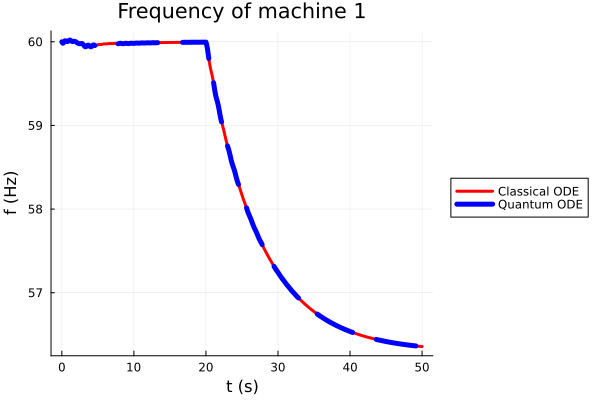

In [8]:
time_array = 0.0:0.01:50.01
p = plot(time_array, [sol1_small[:,10]/(2*pi); sol2_small[:,10]/(2*pi)], title = "Frequency of machine 1", label = "Classical ODE", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1_small[:,10]/(2*pi); qsol2_small[:,10]/(2*pi)], label = "Quantum ODE", lc = :blue, ls = :dash, lw = 5)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!("f (Hz)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

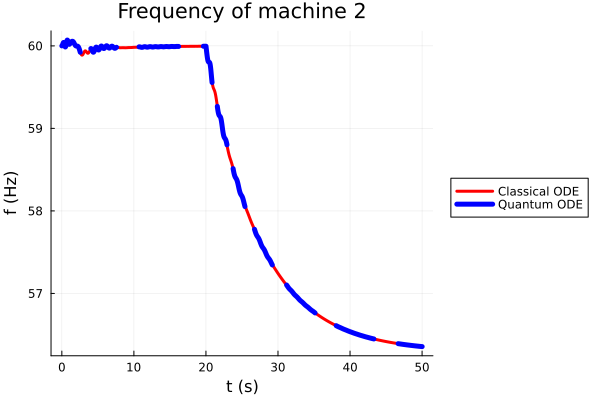

In [9]:
p = plot(time_array, [sol1_small[:,11]/(2*pi); sol2_small[:,11]/(2*pi)], title = "Frequency of machine 2", label = "Classical ODE", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1_small[:,11]/(2*pi); qsol2_small[:,11]/(2*pi)], label = "Quantum ODE", lc = :blue, ls = :dash, lw = 5)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!("f (Hz)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

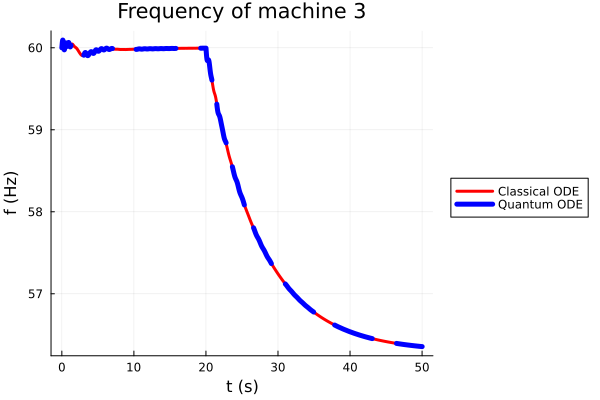

In [10]:
p = plot(time_array, [sol1_small[:,12]/(2*pi); sol2_small[:,12]/(2*pi)], title = "Frequency of machine 3", label = "Classical ODE", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1_small[:,12]/(2*pi); qsol2_small[:,12]/(2*pi)], label = "Quantum ODE", lc = :blue, ls = :dash, lw = 5)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!("f (Hz)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

## Large disturbance

#### Classical ODE

In [11]:
#Creating and Solving the first period by classical method.
prob1_large = ODEProblem(three_machine_simp,u01,tspan1,p1);
sol1_large = solve(prob1_large,FBDF(),dt = h, adaptive = false)

#Creating and Solving the second period by classical method.
u02 = sol1_large.u[end]
prob2_large = ODEProblem(three_machine_simp,u02,tspan2,p3);
sol2_large = solve(prob2_large,FBDF(),dt = h, adaptive = false);

#### Quantum ODE

In [12]:
k = 2     # the k_th order of Taylor expansion

#Creating and Solving the first period by quantum computing.
qsol1_large = solve(prob1_large,QuNLDE(k,h),dt = h, adaptive = false)

#Creating and Solving the second period by quantum computing.
u02 = qsol1_large.u[end]
prob2_large = ODEProblem(three_machine_simp,u02,tspan2,p3);
qsol2_large = solve(prob2_large,QuNLDE(k,h),dt = h, adaptive = false);

#### Save the results.

In [13]:
#saving results
using DataFrames
using CSV
#Creating CSV file to save result from classical method.
open("TMIB_ODE_large.csv", "w") do f
    CSV.write(f,[], writeheader=true, header=header)
end

#Creating CSV file to save result from quantum computing.
open("TMIB_quan_large.csv", "w") do f
    CSV.write(f,[], writeheader=true, header=header)
end

sol1_large = transpose(sol1_large)
sol2_large = transpose(sol2_large)
df_sol1_large = DataFrame(sol1_large, :auto)
df_sol2_large = DataFrame(sol2_large, :auto)
CSV.write("TMIB_ODE_large.csv", df_sol1_large,append = true)
CSV.write("TMIB_ODE_large.csv", df_sol2_large,append = true)

qsol1_large = transpose(qsol1_large)
qsol2_large = transpose(qsol2_large)
df_qsol1_large = DataFrame(qsol1_large, :auto)
df_qsol2_large = DataFrame(qsol2_large, :auto)
CSV.write("TMIB_quan_large.csv", df_qsol1_large,append = true)
CSV.write("TMIB_quan_large.csv", df_qsol2_large,append = true);

#### Plotting the results.

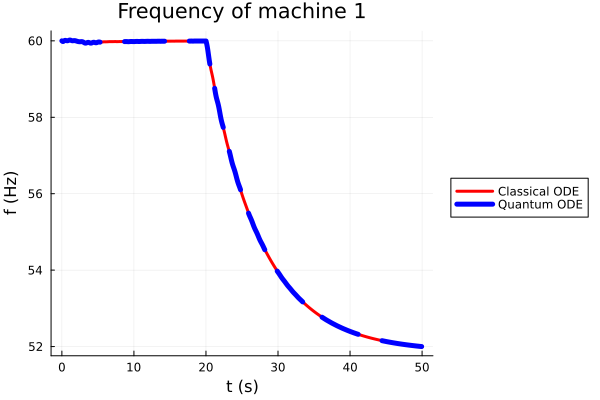

In [14]:
p = plot(time_array, [sol1_large[:,10]/(2*pi); sol2_large[:,10]/(2*pi)], title = "Frequency of machine 1", label = "Classical ODE", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1_large[:,10]/(2*pi); qsol2_large[:,10]/(2*pi)], label = "Quantum ODE", lc = :blue, ls = :dash, lw = 5)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!("f (Hz)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

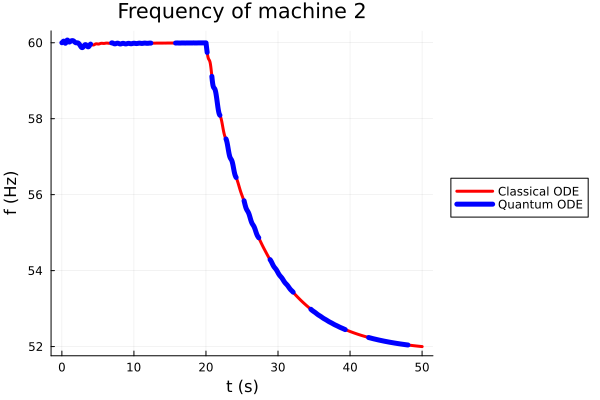

In [15]:
p = plot(time_array, [sol1_large[:,11]/(2*pi); sol2_large[:,11]/(2*pi)], title = "Frequency of machine 2", label = "Classical ODE", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1_large[:,11]/(2*pi); qsol2_large[:,11]/(2*pi)], label = "Quantum ODE", lc = :blue, ls = :dash, lw = 5)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!("f (Hz)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()

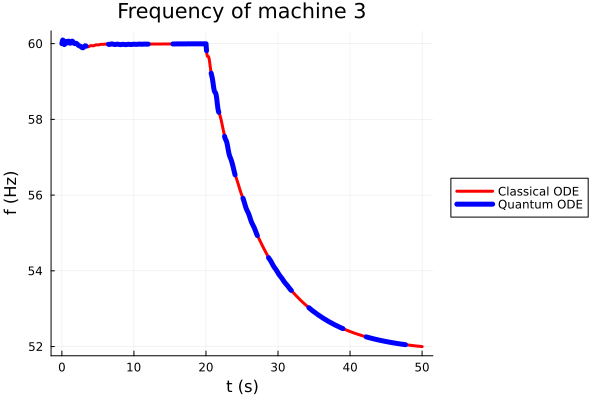

In [16]:
p = plot(time_array, [sol1_large[:,12]/(2*pi); sol2_large[:,12]/(2*pi)], title = "Frequency of machine 3", label = "Classical ODE", lc = :red, ls = :solid, lw = 3) # Plot the figure of phase angle of classical method.
plot!(time_array, [qsol1_large[:,12]/(2*pi); qsol2_large[:,12]/(2*pi)], label = "Quantum ODE", lc = :blue, ls = :dash, lw = 5)                                      # plot the second line of quantum computing in the same figure.
xlabel!("t (s)")
ylabel!("f (Hz)")

# Set the legend outside the plot
plot!(p, legend=:outerright)

# Display the plot
plot!()